# Agent with Long-Time Memory
* We will build an Agent that will help us to **manage a ToDo list**.
* It will decide:
    * **when to save items** to our ToDo list.
    * **to save either a user profile or a collection of ToDo items**.
* In addition to semantic memory (user facts), it will also have **procedural memory**.
    * Remember, the procedural memory is the system prompt. This will allow the user to set preferences for creating ToDo items.

## Recommended learning path
This is a very good project to learn and practice all that you have learned until now.
1. Watch the full video. Focus on understanding the main concepts.
2. Repeat all the steps from scratch by yourself. Focus on understanding the details. Take your time.
3. Think. Plan a list of interesting experiments to modify and improve the project.
4. Experiment with one small feature at a time: clone the project and experiment only with that feature.
5. And again, and again, and again. Until you master it. With the mentality and the motivation of an Olympic Athlete.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 028-agent-with-LT-memory.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## What is TrustCall doing in the background?
* TrustCall allows us to have a deeper understanding of its operations. Here we will show you how to **discover what tool calls were made by TrustCall**.
* We will **add a listener to the Trustcall extractor**. This will pass runs from the extractor's execution to a class, Spy, that we will define. The Spy class will extract **information about what tool calls were made by TrustCall**.

In [6]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [7]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# PAY ATTENTION HERE: see how we add the spy listener.
# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

## In case you are curious about how the Spy was developed...
The **Spy** class tracks the tool calls made during the execution of a process (likely related to AI chat models or an extraction framework like LangChain).

Let's break it down step by step:

#### 1. The `Spy` class
- The class is designed to **record tool calls** from an execution run.
- It has an attribute `self.called_tools`, which is a list to store detected tool calls.

#### 2. The `__call__` method
- This makes the class callable like a function.
- It takes an object `run` (probably representing a process or task execution).
- It uses a queue (`q`) to **traverse through all child runs** (nested executions).

#### 3. Processing runs
- The loop extracts **child runs** recursively, meaning it goes through all levels of execution.
- If the execution (`r`) is of type `"chat_model"`, it extracts tool call information from `r.outputs`.

#### 4. Extracting tool calls
- The tool calls are accessed via:
  ```python
  r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
  ```
  - `generations[0][0]`: Likely refers to the first generated response.
  - `"message"` → `"kwargs"` → `"tool_calls"`: This navigates through a structured data format (probably JSON-like) to retrieve the tool call information.
- This extracted tool call info is appended to `self.called_tools`.

#### 5. Initializing the spy
```python
spy = Spy()
```
- This creates an instance of the `Spy` class, ready to inspect tool calls.

#### Summary (Simple Explanation)
- The **Spy** class keeps track of tools used during a process.
- It goes through the execution history, including nested calls.
- If the process involves a **chat model**, it extracts tool call details.
- The extracted tool call information is stored in `self.called_tools` for later inspection.

## OK. Let's first use Trustcall without the listener.

In [8]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Julio."), 
                AIMessage(content="Nice to meet you, Julio."), 
                HumanMessage(content="Yesterday I visited Sausalito.")]

# PAY ATTENTION HERE: we use the regular extractor.
# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [9]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_FrmbmeMKdSV8uQqdCQncKQW3)
 Call ID: call_FrmbmeMKdSV8uQqdCQncKQW3
  Args:
    content: Julio visited Sausalito yesterday.


In [10]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Julio visited Sausalito yesterday.'


In [11]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_FrmbmeMKdSV8uQqdCQncKQW3'}


In [12]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, what did you do after?"), 
                        HumanMessage(content="I went to Tiburon and prepared a paella in the park."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about finally learn to cook paella for the sake of my girlfriend."),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0', 'Memory', {'content': 'Julio visited Sausalito yesterday.'})]

## And now let's see Trustcall with the listener

In [13]:
# PAY ATTENTION HERE: See how we use the extractor with the listener.
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})

In [14]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_5pJ8BF9bsiFnFRUpXtbbqA2D', 'json_doc_id': '0'}
{'id': 'call_Q3BjEuPA8PDzjLo70w0lL8rC'}


In [15]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_5pJ8BF9bsiFnFRUpXtbbqA2D)
 Call ID: call_5pJ8BF9bsiFnFRUpXtbbqA2D
  Args:
    content:  I went to Tiburon and prepared a paella in the park.
  Memory (call_Q3BjEuPA8PDzjLo70w0lL8rC)
 Call ID: call_Q3BjEuPA8PDzjLo70w0lL8rC
  Args:
    content: I was thinking about finally learning to cook paella for the sake of my girlfriend.


In [16]:
# Parsed responses
for m in result["responses"]:
    print(m)

content=' I went to Tiburon and prepared a paella in the park.'
content='I was thinking about finally learning to cook paella for the sake of my girlfriend.'


In [17]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Add the new memory content about visiting Tiburon and preparing paella in the park to the existing Memory instance.',
    'patches': [{'op': 'add',
      'path': '/content',
      'value': ' I went to Tiburon and prepared a paella in the park.'}]},
   'id': 'call_5pJ8BF9bsiFnFRUpXtbbqA2D',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'I was thinking about finally learning to cook paella for the sake of my girlfriend.'},
   'id': 'call_Q3BjEuPA8PDzjLo70w0lL8rC',
   'type': 'tool_call'}]]

## Let's review what we just did

The previous code demonstrates how to **track tool calls** made by the **TrustCall extractor** in a conversation-processing workflow using LangGraph. Here's a simplified explanation of what each part does:


#### Define Memory Schemas
- **`Memory`** and **`MemoryCollection`** define the structure for storing extracted information.  
- Example: Memories might include facts about the user, such as *"User visited Sausalito yesterday."*


#### Create a Spy Class
- **`Spy`** keeps track of which tools TrustCall uses during processing.  
- It inspects and logs tool calls embedded in the **`run`** structure, capturing details about interactions.


#### Set Up the LLM and Extractor
- **Model (`ChatOpenAI`)** simulates conversation processing.  
- **TrustCall Extractor** is configured to:
  - Use the **`Memory`** tool.  
  - Automatically insert memories extracted from conversations.  

The extractor processes user messages and identifies relevant information to store as memories.


#### Attach Spy to the Extractor
- The extractor is modified (`with_listeners`) to use the **Spy** object.  
- **Spy** listens for tool calls at the end of the extraction process.


#### Process Conversations 
- Conversations are passed into the extractor with an **instruction** to extract memories.  
- The extractor outputs:
  1. **Messages** – The processed conversation. 
  2. **Responses** – The extracted memories.  
  3. **Metadata** – Information about the tool calls used.  


#### Update Conversations and Memories 
- A new conversation is added with updated instructions.  
- **Existing memories** are provided to allow updates and additions.  
- The extractor processes the updates and outputs new data.


#### Inspect Tool Calls 
- The **Spy** collects and logs all tool calls used during the process.  
- It allows developers to see which tools were invoked and analyze how the extractor interacted with them.


#### Purpose of the Code 
This code is primarily for **debugging and monitoring** the behavior of the TrustCall extractor. It helps developers understand how TrustCall uses tools to process and extract information during conversations, ensuring transparency and enabling improvements to the processing pipeline.

## OK. That was good to know. Now let's start building our ToDo Agent.
Our Agent will be able to decide when to update 3 elements in the long-term memory:
* User profile data.
* ToDo items.
* System prompt.

## We will create the UpdateMemory class to select the element in the long-term memory we will update at one particular moment

In [18]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

## Let's review the previous code

#### TypedDict 
- It is used to create a dictionary-like structure where each key has a specific name and type.   

#### UpdateMemory  
- A **class** that acts like a dictionary to represent a **decision on what memory type to update**.  
- It has one key: **`update_type`**, which specifies what kind of memory needs to be updated.

#### Literal  
- Limits the value of **`update_type`** to one of **three predefined options**:
     - `'user'` – Updates user-related memories.  
     - `'todo'` – Updates task-related or to-do list memories.  
     - `'instructions'` – Updates instructions or guidelines stored in memory.  


#### Example Usage
```python
update = UpdateMemory(update_type='user')  # Valid
update = UpdateMemory(update_type='todo')  # Valid
update = UpdateMemory(update_type='notes') # Error! 'notes' is not allowed.
```

#### Purpose
This code helps **categorize memory updates** into specific types, making the system more organized and reducing errors during updates. It ensures only valid memory types are passed, improving reliability.

## With that ready, let's now focus on building the agent
* We will use the router route_message to make a binary decision to save memories.
* The memory collection updating will be handled by Trustcall in the write_memory node, like we did before.

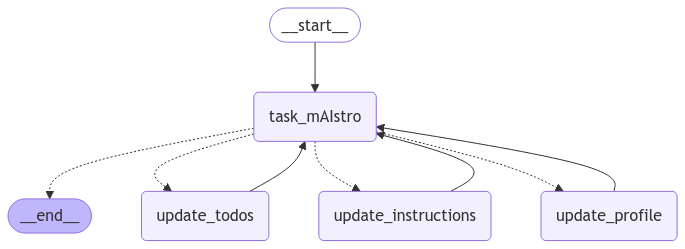

In [19]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}


# PAY ATTENTION HERE: We needed to define this function, that is used in the next one.
# Did the LangGraph team miss this or are we missing something???
def extract_tool_info(tool_calls, tool_name):
    """Extracts and summarizes information about tool calls."""
    updates = []
    for tool_call in tool_calls:
        if tool_call:
            for call in tool_call:
                if call['name'] == tool_name:
                    # Collect the arguments or details about the tool call
                    updates.append(f"Updated {tool_name}: {call['args']}")
    return "\n".join(updates) if updates else f"No updates for {tool_name}."


def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # PAY ATTENTION: here is where the function extract_tool_info is being used.
    # We needed to define it in order to prevent an error. See the previous function definition.
    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## That is a very long code. Let's break it down.

The previous code sets up a **conversation-based chatbot system** using LangGraph and TrustCall to manage and update **long-term memory** (user profile, ToDo list, and instructions) based on user inputs. Here's a **simplified explanation** of what each part does:


#### Define Schemas for Memory
- **Profile Schema:**  
  Stores personal details about the user, such as name, location, job, connections, and interests.  
- **ToDo Schema:**  
  Manages tasks with details like deadlines, status, and solutions.  


#### TrustCall Extractors
- **Profile Extractor:**  
  Updates user profiles based on conversations.  
- **ToDo Extractor:**  
  Updates tasks in the ToDo list based on chat inputs.  
- **Instruction Updater:**  
  Updates chatbot instructions for handling tasks based on user preferences.  

Each extractor works with tools that are specifically designed to process the schemas and store relevant information.


#### Instructions for the Chatbot
- **MODEL_SYSTEM_MESSAGE:**  
  Guides the chatbot to:
  1. Update the profile if the user shares personal info.  
  2. Update ToDo lists if tasks are mentioned.  
  3. Update instructions based on user preferences.  
- **TRUSTCALL_INSTRUCTION:**  
  Ensures extracted data is reflected as memories using TrustCall tools.  


#### Define Nodes (Functions) for Memory Updates
- **`task_mAIstro`:**  
  Loads existing memories (profile, tasks, and instructions) and responds based on user input, deciding which updates are needed.  
- **`update_profile`:**  
  Updates the user profile if personal information is detected in messages.  
- **`update_todos`:**  
  Updates the ToDo list with new tasks or changes based on user input.  
- **`update_instructions`:**  
  Updates chatbot preferences based on how the user wants the ToDo list handled.  

Each function:
1. Loads existing memory from storage.  
2. Processes the chat messages.  
3. Saves updated memory back into the store.  
4. Confirms updates to the user if required.


#### Decision Routing
- **`route_message`:**  
  Decides which node to process based on the latest tool call:  
  - Update profile → `update_profile`.  
  - Update tasks → `update_todos`.  
  - Update instructions → `update_instructions`.  
  - End processing if no update is required.


#### Build the Conversation Flow
- **StateGraph:**  
  Defines the flow of conversation:  
  1. Starts at **`task_mAIstro`** to process inputs.  
  2. Routes updates to profile, tasks, or instructions as needed.  
  3. Loops back to the start for continued processing.  

- **Memory Management:**  
  - **`InMemoryStore`:** Stores long-term memory across multiple interactions.  
  - **`MemorySaver`:** Tracks short-term memory for the current conversation.  


#### Visualize the Graph
- Generates a **flowchart diagram** showing the process flow using Mermaid.js to visualize connections between nodes.  


#### Example Workflow
**Input:**  
*User: "I need to finish a report by Friday."*  

**Process:**  
1. Detects a task and updates the ToDo list.  
2. Stores "Finish report" with a deadline of Friday.  
3. Confirms the task addition to the user.  

**Output:**  
*Bot: "I've added 'Finish report' to your ToDo list with a deadline on Friday."*  

This setup enables dynamic, **memory-driven interactions**, making the chatbot smarter and more context-aware over time!

## That was a good overview. Now let's dive into the most relevant parts of this code.

## Let's review the segment that defines the schemas for Profile and ToDo memories

This segment of code defines **data structures** for storing information about the user and their tasks using Python's **Pydantic library**. It ensures data is organized and validated based on predefined formats.  

#### User Profile Schema (`Profile`)

This class represents **personal information** about the user.  

- **`name`:** Stores the user's name (optional).  
- **`location`:** Stores where the user is located (optional).  
- **`job`:** Stores the user's job or profession (optional).  
- **`connections`:** A list of people connected to the user (e.g., family, friends, coworkers).  
  - Default is an **empty list**.  
- **`interests`:** A list of the user's hobbies or interests.  
  - Default is an **empty list**.  

**Purpose:**  
Keeps track of personal details about the user to **personalize responses** and adapt interactions based on their profile.


#### ToDo Schema (`ToDo`)

This class defines the structure for storing and managing **tasks**.  

- **`task`:** A description of the task to be completed (required).  
- **`time_to_complete`:** Estimated time to complete the task, in minutes (optional).  
- **`deadline`:** A specific **date and time** by which the task should be completed (optional).  
- **`solutions`:** A list of **actionable steps or ideas** to complete the task.  
  - Must contain at least **one solution** and defaults to an **empty list**.  
- **`status`:** Tracks the **progress** of the task.  
  - Can be one of these values:  
    - `"not started"` (default)  
    - `"in progress"`  
    - `"done"`  
    - `"archived"`  

**Purpose:**  
Manages the **ToDo list** by storing tasks, deadlines, and progress to help the chatbot track and update activities effectively.


#### Example Data

**User Profile:**
```python
profile = Profile(
    name="Alice",
    location="San Francisco",
    job="Engineer",
    connections=["Bob", "Carol"],
    interests=["hiking", "photography"]
)
```

**ToDo Task:**
```python
task = ToDo(
    task="Finish project report",
    time_to_complete=120,
    deadline=datetime(2024, 12, 31, 17, 0),
    solutions=["Draft outline", "Add visuals", "Proofread"],
    status="in progress"
)
```


#### How It Fits in the Code
- The **Profile** schema supports **personalization** by storing user information.  
- The **ToDo** schema manages **tasks and updates**, enabling the chatbot to **track progress** and suggest solutions.  
- Both schemas integrate with TrustCall to **extract, update, and store memories** automatically during conversations.

## The TrustCall Extractor is so easy that it does not require explanation
* As you can see in the code, there is nothing new in the extractor definition.

## That was very interesting. Now let's review the segment where we give instructions for the chatbot

This segment of the code defines **instructions for the chatbot** to guide its behavior when interacting with the user. It ensures the chatbot knows how to **analyze messages**, **decide what to update**, and **respond appropriately**. Here's a simple explanation of each part:

#### Chatbot Instructions (`MODEL_SYSTEM_MESSAGE`):
This section defines the chatbot's **role and rules** for processing conversations.  

- **Role:**  
  The chatbot is a **helpful assistant** designed to:
  1. Keep track of the user's **profile** (personal info).  
  2. Manage the user's **ToDo list** (tasks).  
  3. Follow **preferences** for updating tasks (instructions).  

- **Data Context:**  
  The chatbot is given the **current state** of:  
  - **User Profile:** Details about the user.  
  - **ToDo List:** List of tasks.  
  - **Instructions:** Preferences for task management.  

- **Decision Rules:**  
  The chatbot analyzes user messages and decides:  
  1. **Update Profile:** If the user shares personal info (e.g., name, location).  
  2. **Update ToDo List:** If tasks or deadlines are mentioned.  
  3. **Update Instructions:** If preferences about task updates are specified.  

- **Responses:**  
  - **Notify** the user about **ToDo updates**.  
  - **Do not notify** about **profile** or **instruction updates** to avoid interrupting the flow.  
  - Always **prioritize updating the ToDo list** without asking for permission.  

- **Final Rule:**  
  After analyzing the input, **respond naturally** to continue the conversation—whether updates are made or not.


#### TrustCall Instruction (`TRUSTCALL_INSTRUCTION`) 
This is an **instruction template** for TrustCall to handle memory updates efficiently.  

- **Purpose:**  
  It tells TrustCall to:
  1. **Analyze the interaction** and decide what data to save.  
  2. Use **parallel tool calls** to **update multiple memories** (e.g., profile and tasks) at the same time.  

- **System Time Placeholder:**  
  It includes the **current time** to provide context for updates (useful for tracking deadlines).


#### ToDo Update Instructions (`CREATE_INSTRUCTIONS`) 
This template is used for **adjusting instructions** on how the chatbot should manage ToDo list updates.  

- **Purpose:**  
  Based on **user feedback**, the chatbot can:
  1. **Modify rules** for adding or updating tasks.  
  2. **Reflect preferences**, such as how detailed tasks should be or whether reminders are needed.  

- **Current Instructions Placeholder:**  
  It includes the **existing instructions** as context and allows the chatbot to **refine them** based on recent interactions.


#### Simplified Example Workflow

**User:**  
*"I need to book a flight for next week and also follow up on my visa application."*  

**Chatbot Actions:**  
1. Detects **tasks** → Updates ToDo list.  
2. Prioritizes updating the ToDo list without asking for confirmation.  
3. Responds: *"I've added 'Book a flight for next week' and 'Follow up on visa application' to your ToDo list."*  

**User Later:**  
*"Remind me about these tasks a day before the deadlines."*  

**Chatbot Actions:**  
1. Updates **instructions** based on the request.  
2. Does **not notify** the user about this update but uses it for future reminders.

## Excellent. Now let's review the segment where we define the nodes.

This segment defines **four functions** (called **nodes**) that handle different tasks in the chatbot's **memory management system**. Each function is responsible for **updating a specific type of memory** (profile, ToDo list, or instructions) or **processing user input** to decide what needs updating.

#### NODE `task_mAIstro`: Load Memories and Generate a Response 

**What it does:**
- **Purpose:**  
  Loads existing memories (profile, tasks, instructions) and **personalizes responses** based on the user's data.  

**Steps:**
1. **Identify the User:**  
   Gets the **user ID** from the configuration to fetch their data.  

2. **Retrieve Memories:**  
   - **Profile:** Loads saved user info like name or location.  
   - **ToDo List:** Loads tasks and deadlines.  
   - **Instructions:** Loads preferences for managing tasks.  

3. **Prepare System Message:**  
   Formats the chatbot's **system message** with the user's current data.  

4. **Respond to the User:**  
   Uses the **chat model** to generate a response, taking the user's messages and saved memories into account.  

**Output:**  
Returns the chatbot's **response message** to continue the conversation.  


#### NODE `update_profile`: Update User Profile

**What it does:**
- **Purpose:**  
  Checks if the user mentioned any **personal information** (e.g., name, job) and **updates their profile**.  

**Steps:**
1. **Retrieve Existing Profile:**  
   Fetches the saved profile data for context.  

2. **Prepare Messages:**  
   Combines the chat history and instructions for TrustCall to analyze the messages.  

3. **Extract New Info:**  
   Uses the **TrustCall extractor** to detect and extract **new profile details**.  

4. **Save Profile Updates:**  
   Stores the **new or updated profile** in the memory database.  

5. **Notify the Chatbot:**  
   Confirms that the profile was updated (but does **not inform the user** directly).  

**Output:**  
Returns a **tool message** confirming the update to the chatbot, which it uses internally.  


#### NODE `update_todos`: Update ToDo List

**Note: the update_todos node uses the extract_tool_info function**
* We explain in simple terms the extract_tool_info function in the section below.

**What it does:**
- **Purpose:**  
  Detects and **updates tasks** in the user's ToDo list based on the conversation.  

**Steps:**
1. **Retrieve Existing Tasks:**  
   Loads saved tasks to check for updates or additions.  

2. **Prepare Messages:**  
   Formats the chat history and instructions for TrustCall analysis.  

3. **Spy on Tool Calls:**  
   Adds a **Spy** to track tool calls made by TrustCall for debugging purposes.  

4. **Extract Task Updates:**  
   Uses the **TrustCall extractor** to identify **new or updated tasks** and stores them.  

5. **Notify the Chatbot and User:**  
   Confirms updates to the ToDo list and **informs the user** about the changes.  

**Output:**  
Returns a **tool message** summarizing the updates to the chatbot, which it relays to the user.  


#### NODE `update_instructions`: Update Task Management Preferences

**What it does:**
- **Purpose:**  
  Updates the chatbot's **instructions** for managing tasks based on user preferences.  

**Steps:**
1. **Retrieve Current Instructions:**  
   Loads existing preferences, if any.  

2. **Prepare Message:**  
   Formats a prompt to **reflect and update preferences** based on the latest interaction.  

3. **Generate Updated Instructions:**  
   Uses the **chat model** to create **revised instructions** for handling tasks.  

4. **Save the Updates:**  
   Overwrites the **existing instructions** in memory with the new version.  

5. **Notify the Chatbot:**  
   Confirms that the instructions were updated (but does **not notify the user**).  

**Output:**  
Returns a **tool message** confirming the update to the chatbot for internal use.  


#### Overall Purpose of the Nodes
These functions:
1. **Load and analyze data** stored in memory.  
2. **Decide what needs updating** based on user input (profile, tasks, or instructions).  
3. **Update and save memories** using TrustCall extractors.  
4. **Inform the chatbot** (and sometimes the user) about updates to keep conversations context-aware.  


#### Simplified Example Workflow

**User:**  
*"I moved to New York and need to book a flight by Friday."*  

**Step-by-Step Process:**
1. **`task_mAIstro`:**  
   Detects the user mentioned a new **location** and a **task**.  

2. **`update_profile`:**  
   Updates the **profile** with "New York" as the location.  

3. **`update_todos`:**  
   Adds "Book a flight by Friday" to the **ToDo list** and **notifies the user**.  

4. **`update_instructions`:**  
   Checks if the user specified preferences (e.g., reminders) and **updates instructions** if needed.  

**Chatbot Response:**  
*"I've added 'Book a flight by Friday' to your ToDo list."*  

## Line-by-Line Explanation of `task_mAIstro` Function
The `task_mAIstro` function is the main node in the LangGraph workflow that retrieves stored information about the user and their tasks, and then generates a response based on that information.


#### Function Definition
```python
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):
```
- **`state`**: Holds the chat history (messages between the user and the chatbot).
- **`config`**: Contains additional configuration settings (like the user ID).
- **`store`**: Stores long-term memory, such as user profile data and tasks.


#### Step 1: Get the User ID
```python
user_id = config["configurable"]["user_id"]
```
- Extracts the **user's unique identifier** from the configuration.
- This ID is used to **retrieve the correct user data** from storage.


#### Step 2: Retrieve User Profile
```python
namespace = ("profile", user_id)
memories = store.search(namespace)
if memories:
    user_profile = memories[0].value
else:
    user_profile = None
```
- **Searches the memory store** for any saved **profile information** (e.g., name, location, job, interests).
- If a profile exists, it is assigned to `user_profile`.
- If **no profile** is found, it is set to `None`.


#### Step 3: Retrieve To-Do List
```python
namespace = ("todo", user_id)
memories = store.search(namespace)
todo = "\n".join(f"{mem.value}" for mem in memories)
```
- **Searches the memory store** for the user's saved **To-Do list**.
- Converts the stored tasks into a **single formatted string**.


#### Step 4: Retrieve User Preferences
```python
namespace = ("instructions", user_id)
memories = store.search(namespace)
if memories:
    instructions = memories[0].value
else:
    instructions = ""
```
- **Searches the memory store** for any saved **user preferences** related to task updates.
- If preferences exist, they are assigned to `instructions`, otherwise, it is set to an empty string.


#### Step 5: Format the System Message
```python
system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)
```
- **Fills in the system message template** (`MODEL_SYSTEM_MESSAGE`) with:
  - The user’s **profile**.
  - Their **To-Do list**.
  - Their **task update preferences**.
- This ensures the chatbot **has context** before responding.


#### Step 6: Generate a Response
```python
response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])
```
- Calls the **AI model (`gpt-4o`)** to process the user's message **along with the retrieved memory**.
- Uses **`UpdateMemory` tool** to handle any necessary memory updates.
- The **`invoke` function** sends the **system message + conversation history** to the model.
- The AI **generates a response** based on the stored information.


#### Step 7: Return the Response
```python
return {"messages": [response]}
```
- The chatbot’s **generated response** is **returned**.
- This response will be sent **back to the user** in the conversation.


#### Summary of What `task_mAIstro` Does
1. **Retrieves user data** (profile, tasks, preferences) from memory.
2. **Formats a system message** with this information.
3. **Sends the formatted message + chat history** to the AI model.
4. **Generates and returns a chatbot response**.

This function ensures that the chatbot **remembers past conversations** and **responds in a personalized way**.

## Line-by-Line Explanation of `update_profile` Function
The `update_profile` function **analyzes the chat history** and **updates the user's profile information** in the long-term memory store.


#### Function Definition
```python
def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
```
- **`state`**: Holds the conversation history (messages exchanged between the user and the chatbot).
- **`config`**: Configuration settings (includes user ID).
- **`store`**: The **memory storage system** where user profiles are saved.


#### Step 1: Get the User ID
```python
user_id = config["configurable"]["user_id"]
```
- Extracts the **user's unique identifier**.
- This ID helps retrieve and update the **correct user's profile**.


#### Step 2: Define Where Profile Data is Stored
```python
namespace = ("profile", user_id)
```
- Creates a **namespace** (a label) for storing **profile-related data**.
- This ensures profile updates are saved under the correct category.


#### Step 3: Retrieve Existing Profile Information
```python
existing_items = store.search(namespace)
```
- **Checks if any profile information already exists** in memory.
- If the user **has shared profile details before**, they will be stored in `existing_items`.


#### Step 4: Format Profile Data for Processing
```python
tool_name = "Profile"
existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                      for existing_item in existing_items]
                      if existing_items
                      else None
                    )
```
- If there are **existing profile details**, they are **formatted** into a structured list.
- If **no profile data exists**, it is set to `None`.


#### Step 5: Prepare the System Instruction
```python
TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
```
- Formats the **system instruction template** (`TRUSTCALL_INSTRUCTION`) by inserting the **current timestamp**.
- This instruction helps the AI understand what to do with the new user input.


#### Step 6: Merge Chat History for Processing
```python
updated_messages = list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))
```
- **Merges** the **instruction** with the user's latest messages.
- The function **excludes the very last message** in `state["messages"]` because that one is the tool call itself.


#### Step 7: Extract Updated Profile Information
```python
result = profile_extractor.invoke({"messages": updated_messages, 
                                   "existing": existing_memories})
```
- Calls the **profile extractor** (`profile_extractor`) to analyze the messages.
- **Identifies new profile details** from the user's conversation.
- Uses **existing profile data (if any)** for context.


#### Step 8: Store the Updated Profile Information
```python
for r, rmeta in zip(result["responses"], result["response_metadata"]):
    store.put(namespace,
              rmeta.get("json_doc_id", str(uuid.uuid4())),
              r.model_dump(mode="json"),
    )
```
- **Loops through extracted profile updates**.
- **Saves the updated profile** in the memory store (`store.put()`).
- If the update does not have an ID, a new **UUID** (unique identifier) is generated.


#### Step 9: Send a Confirmation Message
```python
tool_calls = state['messages'][-1].tool_calls
return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id": tool_calls[0]['id']}]}
```
- Retrieves the **original tool call ID** to link the update to the correct request.
- **Returns a response** to confirm the profile has been updated.


#### Summary of What `update_profile` Does
1. **Retrieves the user’s profile data** (if available).
2. **Formats the profile data** for processing.
3. **Prepares an instruction message** to guide AI extraction.
4. **Analyzes chat history** to find new profile updates.
5. **Stores any extracted profile updates** in memory.
6. **Returns a confirmation message** that the update was successful.

This function ensures the chatbot **remembers user details** (name, location, interests, etc.) and **keeps them up-to-date**.

## About the extract_tool_info function used by the update_todos Node

We needed to add the helper function **`extract_tool_info`** in order for this code to work. **It was not originally in the project prepared by the LangGraph team**. This function is used to analyze and summarize information about tool calls (actions taken by the system to update or manage data). Here's a simple explanation about the coding of this function (you can see the code before the update_todos node):

#### What does it do?
The function:
1. **Takes Input**: 
   - A list of tool calls (`tool_calls`) made during the chatbot's process.
   - The name of a specific tool (`tool_name`) that we are interested in analyzing.
2. **Finds Relevant Tool Calls**:
   - It loops through all tool calls to check if the tool name matches the one specified.
3. **Extracts Information**:
   - For matching tool calls, it collects details about what arguments or updates were made using that tool.
4. **Formats a Summary**:
   - Creates a human-readable summary of the updates made by the tool.
   - If no updates were found, it returns a message saying so.

#### Step-by-Step Explanation
1. **Initialize an Empty List**:
   - `updates = []`: This list will store the summary of updates for the specified tool.

2. **Loop Through Tool Calls**:
   ```python
   for tool_call in tool_calls:
   ```
   - Each `tool_call` is checked to see if it contains updates.

3. **Nested Loop for Individual Calls**:
   ```python
   for call in tool_call:
   ```
   - Each `call` within a `tool_call` is examined.

4. **Match Tool Name**:
   ```python
   if call['name'] == tool_name:
   ```
   - If the `name` of the tool matches the specified `tool_name`, we process it.

5. **Extract Arguments or Details**:
   ```python
   updates.append(f"Updated {tool_name}: {call['args']}")
   ```
   - Adds a summary like `"Updated ToDo: {...}"` to the `updates` list.

6. **Return Results**:
   ```python
   return "\n".join(updates) if updates else f"No updates for {tool_name}."
   ```
   - If there are updates, it joins them into a single string separated by newlines.
   - If no updates are found, it returns `"No updates for {tool_name}."`


#### Why is it important?
- This function provides a **clear summary** of what actions were taken by a specific tool during a chatbot session.
- It's helpful for:
  - **Debugging**: To see how tools were used and what updates they made.
  - **User Feedback**: To inform users about changes (e.g., updated ToDo list).


#### Example
Suppose the chatbot made these tool calls:
```python
tool_calls = [
    [{'name': 'ToDo', 'args': {'task': 'Buy groceries', 'status': 'done'}}],
    [{'name': 'Profile', 'args': {'name': 'Julio', 'location': 'Madrid'}}],
]
```

If you call:
```python
extract_tool_info(tool_calls, 'ToDo')
```

It will return:
```
"Updated ToDo: {'task': 'Buy groceries', 'status': 'done'}"
```

If no `ToDo` updates were found, it would return:
```
"No updates for ToDo."
```

## Line-by-Line Explanation of `update_todos` Function
The `update_todos` function **analyzes the chat history** and **updates the user's To-Do list** in the long-term memory store.


#### Function Definition
```python
def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):
```
- **`state`**: Holds the conversation history (messages between the user and the chatbot).
- **`config`**: Contains configuration settings (including the user ID).
- **`store`**: The **long-term memory storage system** where To-Do tasks are saved.


#### Step 1: Get the User ID
```python
user_id = config["configurable"]["user_id"]
```
- Retrieves the **user's unique identifier**.
- This ID is used to **fetch and update the user's To-Do list**.


#### Step 2: Define Where To-Do Data is Stored
```python
namespace = ("todo", user_id)
```
- Defines a **namespace** for storing **To-Do list items**.
- This ensures tasks are saved in the correct category.


#### Step 3: Retrieve Existing To-Do List
```python
existing_items = store.search(namespace)
```
- Searches the memory store for **previously saved tasks**.
- If the user **already has tasks**, they will be stored in `existing_items`.


#### Step 4: Format Existing Tasks for Processing
```python
tool_name = "ToDo"
existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                      for existing_item in existing_items]
                      if existing_items
                      else None
                    )
```
- If there are **existing tasks**, they are **formatted** into a structured list.
- If **no tasks** exist, it is set to `None`.


#### Step 5: Prepare the System Instruction
```python
TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
```
- Formats the **system instruction template** (`TRUSTCALL_INSTRUCTION`) by inserting the **current timestamp**.
- This instruction helps the AI **understand how to process the new To-Do list updates**.


#### Step 6: Merge Chat History for Processing
```python
updated_messages = list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))
```
- **Merges** the **instruction** with the user's recent messages.
- The function **excludes the very last message** in `state["messages"]` because that one is the tool call itself.


#### Step 7: Initialize a Spy (for Debugging)
```python
spy = Spy()
```
- Creates a **spy object** to track the AI model’s tool calls.
- This is useful for **debugging and verifying updates**.


#### Step 8: Create the To-Do Extractor
```python
todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
).with_listeners(on_end=spy)
```
- **Creates an AI-powered tool (`todo_extractor`)** that can:
  - Extract new tasks from the chat.
  - Update existing tasks.
  - Insert new tasks into the To-Do list.
- The `spy` is attached to **monitor updates**.


#### Step 9: Extract To-Do List Updates
```python
result = todo_extractor.invoke({"messages": updated_messages, 
                                "existing": existing_memories})
```
- Calls the AI tool to **analyze the chat** and **identify To-Do updates**.
- Uses **previous tasks (if any) for context**.


#### Step 10: Store Updated Tasks
```python
for r, rmeta in zip(result["responses"], result["response_metadata"]):
    store.put(namespace,
              rmeta.get("json_doc_id", str(uuid.uuid4())),
              r.model_dump(mode="json"),
    )
```
- **Loops through the extracted task updates**.
- **Saves the updated To-Do list** in memory.
- If a task **does not have an ID**, a new **UUID** (unique identifier) is created.


#### Step 11: Retrieve the Original Tool Call
```python
tool_calls = state['messages'][-1].tool_calls
```
- Retrieves the **original tool call ID** to link the update to the correct request.


#### Step 12: Extract and Summarize Updates
```python
todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
```
- Uses the `extract_tool_info` function to **summarize what changes were made**.
- This ensures the chatbot **can inform the user of the update**.


#### Step 13: Return a Confirmation Message
```python
return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id": tool_calls[0]['id']}]}
```
- **Returns a response** confirming the To-Do list update.
- This **notifies the chatbot** that the task update was successful.


#### Summary of What `update_todos` Does
1. **Retrieves the user’s To-Do list** (if available).
2. **Formats the existing tasks** for AI processing.
3. **Prepares a system instruction** for analyzing task updates.
4. **Merges recent chat history** for context.
5. **Uses an AI tool to extract To-Do updates** from the conversation.
6. **Stores the updated tasks** in the long-term memory.
7. **Summarizes the changes** for the chatbot.
8. **Returns a confirmation message** that the update was successful.

This function ensures that the chatbot **remembers and updates the user's tasks** effectively.

## Line-by-Line Explanation of `update_instructions` Function
The `update_instructions` function **analyzes the chat history** and **updates the user's preferences** for how their To-Do list should be managed.


#### Function Definition
```python
def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):
```
- **`state`**: Contains the conversation history (messages between the user and the chatbot).
- **`config`**: Includes configuration settings (like the user ID).
- **`store`**: The **long-term memory storage** where To-Do preferences are saved.


#### Step 1: Get the User ID
```python
user_id = config["configurable"]["user_id"]
```
- Retrieves the **user's unique identifier**.
- This ID is used to **fetch and update the user's To-Do list preferences**.


#### Step 2: Define Where To-Do Preferences Are Stored
```python
namespace = ("instructions", user_id)
```
- Defines a **namespace** for storing **task management preferences**.
- This ensures **preferences are saved in the correct category**.


#### Step 3: Retrieve Existing To-Do Preferences
```python
existing_memory = store.get(namespace, "user_instructions")
```
- Searches the **memory store** for **previously saved user instructions** on how they prefer tasks to be updated.
- If the user **has provided preferences before**, they are stored in `existing_memory`.


#### Step 4: Format the Current Preferences
```python
system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
```
- Uses a **template (`CREATE_INSTRUCTIONS`)** to **generate a system message**.
- Inserts **the existing preferences** (if any) or sets them to `None` if none exist.
- This system message **guides the AI on how to process user instructions**.


#### Step 5: Generate Updated Instructions
```python
new_memory = model.invoke([SystemMessage(content=system_msg)] + state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])
```
- Sends **a request to the AI model (`gpt-4o`)** to:
  - Analyze the **chat history**.
  - Understand **how the user wants their tasks managed**.
  - Generate **updated instructions** based on the conversation.
- **How it works:**
  - The **system message** (with old instructions) is sent first.
  - The **user's chat history** is added next.
  - A final message **explicitly asks the AI to update the instructions**.


#### Step 6: Save the Updated Preferences
```python
key = "user_instructions"
store.put(namespace, key, {"memory": new_memory.content})
```
- Saves the **updated instructions** into the memory store under `"user_instructions"`.


#### Step 7: Retrieve the Original Tool Call
```python
tool_calls = state['messages'][-1].tool_calls
```
- Retrieves the **original tool call ID** so the update can be linked to the correct request.


#### Step 8: Return a Confirmation Message
```python
return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id": tool_calls[0]['id']}]}
```
- Returns a **confirmation response** stating that the **instructions have been updated**.
- This ensures the chatbot **acknowledges the update** and continues working with the new preferences.


#### Summary of What `update_instructions` Does
1. **Retrieves the user’s To-Do list preferences** (if available).
2. **Formats a system message** with the current preferences.
3. **Merges recent chat history** for context.
4. **Asks the AI model to generate updated instructions**.
5. **Stores the updated instructions** in long-term memory.
6. **Returns a confirmation message** that the update was successful.

This function ensures that the chatbot **adapts to how the user wants their tasks to be managed**, making interactions more personalized.

## Good. Now let's review the segment where we define the Router

This segment of the code defines a **decision-making function** called `route_message`. It **analyzes the user's latest message** and **decides what action the chatbot should take next**.  


#### Purpose
The function **routes the conversation flow** based on the type of information detected in the user's message (e.g., profile update, task update, or instructions update).


#### What It Does 

1. **Check the Latest Message:**  
   - Retrieves the **last message** from the chat history (`state['messages'][-1]`).  
   - Looks for any **tool calls** (special actions triggered by the chatbot: in our case, the 3 types of updates).  

2. **No Tool Calls? End the Process:**  
   - If the message has **no tool calls** (the 3 types of updates), it **ends** the process (`return END`).  
   - This means no updates to memory are needed, so the chatbot simply continues the conversation.  

3. **Identify the Tool Call Type:**  
   - If the message **does contain tool calls**, it **checks what type of update** is requested in the tool call.  

4. **Decide the Next Action:**  
   Based on the **update type**:
   - `"user"` → Update the **user profile** (`return "update_profile"`).  
   - `"todo"` → Update the **ToDo list** (`return "update_todos"`).  
   - `"instructions"` → Update the **instructions** (`return "update_instructions"`).  
   - **Else:** If the update type is **not recognized**, it raises an **error** (`ValueError`).  


#### How It Fits into the Workflow

- This function acts like a **traffic director** for the chatbot.  
- After analyzing the user's message, it **decides which function (node) to run next**:
  - **Profile updates** → `update_profile`.  
  - **ToDo list updates** → `update_todos`.  
  - **Instruction updates** → `update_instructions`.  
  - **No updates needed** → Ends the process.  


#### Example Workflow

**User Message:**  
*"I need to add 'Submit tax report' to my tasks and update my location to Madrid."*  

**Step-by-Step Process:**
1. The chatbot detects **two tool calls**:  
   - **Update ToDo** (task: "Submit tax report").  
   - **Update Profile** (location: "Madrid").  

2. The first tool call (`"todo"`) is processed → **route_message** directs the flow to `update_todos`.  

3. Once the ToDo list is updated, the chatbot **loops back** and processes the next tool call (`"user"`), routing it to `update_profile`.  

4. After processing both updates, the chatbot **resumes the conversation**.


#### Key Takeaways 

- **Decides the Next Step:**  
  Routes the chatbot to handle **profile, task, or instruction updates** based on the user's input.  

- **Flexible and Context-Aware:**  
  Allows the chatbot to **dynamically respond** to multiple types of updates without requiring predefined commands.  

- **Error Handling:**  
  Raises an error if an **unknown update type** is detected, ensuring **data integrity**.  

This makes the chatbot **smart and adaptive**, capable of **multi-step processing** in a single conversation.

## Line-by-Line Explanation of the `route_message` Function

The `route_message` function is a conditional edge function in the LangGraph flow, which means it determines the next step in the workflow based on the last user interaction.

#### Function Definition
```python
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:
```
- This function **takes in three arguments**:
  - `state`: The current state of the conversation (contains message history).
  - `config`: Configuration settings for the LangGraph execution.
  - `store`: A storage system where long-term memory is maintained.
- The function **returns one of four possible values**:
  - `"update_profile"` → If user profile information needs updating.
  - `"update_todos"` → If a task-related update is needed.
  - `"update_instructions"` → If user preferences for updating tasks need modifying.
  - `END` → If no update is required, the process stops.


#### Step 1: Get the Last User Message
```python
message = state['messages'][-1]
```
- Retrieves the **latest message** from the conversation history.
- This message is the basis for deciding what action to take next.


#### Step 2: Check if There Are Any Tool Calls
```python
if len(message.tool_calls) == 0:
    return END
```
- If **no tool calls** are present in the last message, **there's nothing to update**, so the function **ends the process**.


#### Step 3: Get the First Tool Call
```python
else:
    tool_call = message.tool_calls[0]
```
- If there are **tool calls** (i.e., some update is needed), the function **takes the first one** to process.


#### Step 4: Determine the Update Type
```python
if tool_call['args']['update_type'] == "user":
    return "update_profile"
```
- If the tool call specifies `"user"` in the `update_type`, the function **routes the process to `update_profile`**.
- This means the user's profile (name, job, interests, etc.) needs an update.

```python
elif tool_call['args']['update_type'] == "todo":
    return "update_todos"
```
- If `"todo"` is specified, the function **routes the process to `update_todos`**.
- This means the user's ToDo list requires an update (adding/editing/deleting a task).

```python
elif tool_call['args']['update_type'] == "instructions":
    return "update_instructions"
```
- If `"instructions"` is specified, the function **routes the process to `update_instructions`**.
- This means the chatbot's **guidelines for managing the user's tasks** need updating.


#### Step 5: Handle Unexpected Cases
```python
else:
    raise ValueError
```
- If none of the expected update types are found, **an error is raised**.
- This prevents unexpected behavior in case of invalid tool calls.


#### Summary of What `route_message` Does
1. **Checks the latest user message**.
2. **If no update is needed**, the process ends (`END`).
3. **If an update is needed**, it examines the tool call type:
   - `"user"` → Update user profile (`update_profile`).
   - `"todo"` → Update the ToDo list (`update_todos`).
   - `"instructions"` → Update task management preferences (`update_instructions`).
4. **If an invalid update type is found**, it raises an error.

This function ensures that the chatbot correctly **routes memory updates** based on the user's interactions.

## And finally, let's review the segment where we define the agent workflow

This segment of the code **creates and configures a flowchart-like structure** (called a **graph**) to control how the chatbot processes and updates its memory. It defines the **steps** (nodes) and **connections** (edges) between them, guiding the chatbot's decision-making process.


#### Build the Graph (StateGraph)
```python
builder = StateGraph(MessagesState)
```
- **Purpose:** Sets up a **graph structure** to manage the chatbot's actions.  
- **`MessagesState`:** Keeps track of the **current state of messages** during the conversation.


#### Add Nodes (Steps) 
```python
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
```
- **Nodes = Actions** the chatbot can perform.  
- Adds 4 nodes to the graph:
  1. **`task_mAIstro`:** Decides what memory needs updating.  
  2. **`update_todos`:** Updates the **ToDo list**.  
  3. **`update_profile`:** Updates the **user profile**.  
  4. **`update_instructions`:** Updates **task management preferences**.  


#### Connect Nodes (Flow) 

**Start the Process:**
```python
builder.add_edge(START, "task_mAIstro")
```
- Starts at **`task_mAIstro`** to **analyze user input** and decide what to do next.

**Make Decisions:**
```python
builder.add_conditional_edges("task_mAIstro", route_message)
```
- **`route_message`:** Acts like a **traffic controller** to **direct the flow** based on the user's message.  
  - If the user mentions a task → Go to **`update_todos`**.  
  - If the user shares personal info → Go to **`update_profile`**.  
  - If preferences are specified → Go to **`update_instructions`**.  
  - Otherwise → **End the process**.

**Loop Back for More Updates:**
```python
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")
```
- After **updating memory**, the chatbot **returns to the start** to **process more messages** if needed.  
- This **looping behavior** allows the chatbot to **handle multiple updates** in one session.


#### Set Up Memory Storage

**Long-Term Memory:**
```python
across_thread_memory = InMemoryStore()
```
- Stores **long-term data** like the **user profile, ToDo list, and instructions**.  
- Keeps this data **between conversations** so the chatbot **remembers past interactions**.

**Short-Term Memory:**
```python
within_thread_memory = MemorySaver()
```
- Tracks **short-term data** during the **current chat session**.  
- Useful for **temporary updates** and processing multiple tool calls.


#### Compile the Graph
```python
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)
```
- **Compiles the graph** into a **functional chatbot flow**.  
- **Connects memory storage** to the chatbot, so it can **retrieve and update data** as needed.


#### What the Graph Does

**Example Workflow:**
1. User: *"I need to finish my report by Friday and my name is Alice."*  
2. Starts at **`task_mAIstro`** → Analyzes the input.  
3. Routes to **`update_todos`** → Adds the task "Finish report by Friday."  
4. Loops back → Routes to **`update_profile`** → Updates name to "Alice."  
5. Loops back again → Ends the process since no more updates are needed.  


#### Key Takeaways
- The **graph** is like a **map** that controls how the chatbot **processes user input** and **updates memory**.  
- It **handles multiple updates** in one session by looping back to process more actions if needed.  
- **Long-term memory** keeps track of user data over time, while **short-term memory** manages the current chat session.  
- This design makes the chatbot **flexible, context-aware, and capable of learning** as conversations evolve.

## Wow, that sure was a looooong review! Time now to see the Agent at work.

## Let's start our conversation with the ToDo Agent

In [20]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Julio"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Julio. I live in San Francisco.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Julio. I live in San Francisco.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_naNKe8eiOKIhLVpk7RCQPqA4)
 Call ID: call_naNKe8eiOKIhLVpk7RCQPqA4
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Hello, Julio! How can I assist you today?


## Let's explain in simple terms what we just did

The previous code demonstrates how to use the memory system described earlier to process user input and update the chatbot's memory. Here's a breakdown in simple terms:

#### What is it doing?

1. **Set Up Configuration**
   - A `config` dictionary is created with two identifiers:
     - **`thread_id`**: Represents the current session or "short-term memory."
     - **`user_id`**: Identifies the user (in this case, "Julio") for "long-term memory."

2. **Provide User Input**
   - The `input_messages` list contains the user's input. 
   - In this case, Julio shares personal details: `"My name is Julio. I live in San Francisco."`

3. **Run the Graph**
   - The `graph.stream` function processes the input messages and updates the chatbot's memory system based on the defined workflow.

4. **Stream Results**
   - The `stream_mode="values"` ensures that the graph outputs intermediate results as it processes the input.
   - For each "chunk" (step of processing), the last message in `chunk["messages"]` is printed in a readable format using `pretty_print()`.


#### How does it work in practice?
1. **User Input is Passed to the Graph**:
   - The graph nodes (like `task_mAIstro`, `update_profile`, etc.) process the input message.
   - It determines that the user's input contains personal information (name and location).

2. **Memory Update**:
   - The `update_profile` node is triggered because the input is relevant to the user's profile.
   - A new memory entry is created for "Julio" with their name and location.

3. **Output the Results**:
   - The updated memory or response from the chatbot is streamed and displayed using `pretty_print()`.

## Fine. Let's now add our first task.

In [21]:
# User input for a ToDo
input_messages = [HumanMessage(content="Schedule interviews with candidates for California Sales Manager.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Schedule interviews with candidates for California Sales Manager.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_lqjYq0pgzgoSlvTMLyAknKsy)
 Call ID: call_lqjYq0pgzgoSlvTMLyAknKsy
  Args:
    update_type: todo
================================= Tool Message =================================

Updated ToDo: {'task': 'Schedule interviews with candidates for California Sales Manager.', 'time_to_complete': 120, 'solutions': ['Use scheduling software like Calendly or Doodle to coordinate times.', 'Contact candidates via email or phone to confirm availability.', 'Coordinate with the hiring team to ensure their availability.'], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Schedule interviews with candidates for California Sales Manager" to your ToDo list. Is there anything els

## See how that updated the todos memory. This is what we did.

The previous code demonstrates how the chatbot processes a user's message related to a task and updates the **ToDo list** in its memory. Here's a simplified explanation:

#### What does this code do?

1. **User Input for a Task**
   - The user provides a new message: `"Schedule interviews with candidates for California Sales Manager."`
   - This is interpreted as a task that the chatbot should add to its **ToDo list**.

2. **Run the Graph**
   - The `graph.stream` function processes the input message.
   - It uses the workflow defined in the graph (e.g., nodes like `task_mAIstro` and `update_todos`) to decide how to handle the input.

3. **Update the ToDo List**
   - The workflow identifies that this input is related to a task.
   - It triggers the `update_todos` node, which updates the user's **ToDo list** in memory by adding the task.

4. **Stream Results**
   - As the graph processes the input, it streams intermediate results in `stream_mode="values"`.
   - For each processing step, the last message is displayed in a user-friendly format using `pretty_print()`.


#### How does it work?

1. **Analyze the Input**:
   - The chatbot recognizes that the input describes a task, not personal information or preferences.

2. **Decide to Update ToDo List**:
   - The system routes the input to the `update_todos` node.
   - This node adds the task to the **ToDo list** memory under the user's ID (`Julio`).

3. **Provide Feedback**:
   - The chatbot may confirm the addition of the task by generating a response like:
     ```
     "I've added 'Schedule interviews with candidates for California Sales Manager' to your ToDo list."
     ```

4. **Save to Memory**:
   - The task is stored in the long-term memory, so it can be retrieved or updated later.

## Good. Let's now tell the Agent how to behave and see if that updates the instructions memory.

In [22]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include if they are urgent or non-urgent. If I do not said anything about this matter, assume the task is not urgent.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include if they are urgent or non-urgent. If I do not said anything about this matter, assume the task is not urgent.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_ZRFF0RPJTJjQVnM2R0sHWMJ4)
 Call ID: call_ZRFF0RPJTJjQVnM2R0sHWMJ4
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll make sure to include whether tasks are urgent or non-urgent, and if you don't specify, I'll assume they're not urgent. How else can I assist you today?


## That worked well. Let's see what we just did.

The previous code demonstrates how the chatbot processes a user's message to update **instructions** for managing their **ToDo list**. Here's a simple explanation:

#### What does the code do?

1. **User Input to Update Instructions**
   - The user provides a specific preference: 
     ```
     "When creating or updating ToDo items, include if they are urgent or non-urgent. If I do not say anything about this matter, assume the task is not urgent."
     ```
   - This input tells the chatbot how to handle urgency when creating or updating ToDo tasks.

2. **Run the Graph**
   - The `graph.stream` function processes the message.
   - It uses the workflow defined in the graph to determine that the input relates to **instructions** for managing the **ToDo list**.

3. **Update Instructions**
   - The workflow identifies that this input specifies user preferences for handling ToDo items.
   - It triggers the `update_instructions` node, which updates the chatbot's memory for **instructions** based on the user's message.

4. **Stream Results**
   - The graph processes the input in steps and streams intermediate results using `stream_mode="values"`.
   - The last message is displayed using `pretty_print()`, providing a readable summary of what the chatbot did.


#### How does it work?

1. **Analyze the Input**:
   - The chatbot recognizes that the input contains new instructions for managing ToDo tasks, not personal information or specific tasks.

2. **Decide to Update Instructions**:
   - The system routes the input to the `update_instructions` node.
   - This node updates the **instructions memory** for the user (`Julio`) with the new preference about urgency.

3. **Save and Respond**:
   - The updated instructions are stored in memory, replacing or adding to previous instructions.
   - The chatbot does not explicitly tell the user about instruction updates (as per its design), but it applies the new instructions in future interactions.


While there may not be a direct response to the user in this case, the chatbot will now use this updated instruction when managing tasks. For example, if a user later says, `"Add 'Prepare a presentation' to my ToDo list,"` the chatbot will automatically mark the task as **not urgent** unless the user specifies otherwise.

## Let's see the instruction memory

In [23]:
# Check for updated instructions
user_id = "Julio"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': '<current_instructions>\nWhen creating or updating ToDo items, include if they are urgent or non-urgent. If the user does not specify, assume the task is not urgent.\n</current_instructions>'}


## Did you see? The instruction memory is now updated. Let's review what we just did.

The previous code is used to **retrieve and view the updated instructions** stored in the chatbot's memory for a specific user (`Julio`). Here's a simple explanation:

#### What does the code do?

1. **Specify the User**:
   - The variable `user_id` is set to `"Julio"`, indicating that we want to retrieve instructions associated with Julio.

2. **Search for Instructions**:
   - The `across_thread_memory.search` function is used to look for memory items stored under the **"instructions"** namespace for the user with ID `"Julio"`.
   - `("instructions", user_id)` acts like a label to identify the specific set of instructions in the memory.

3. **Print the Results**:
   - For each memory item found, the code prints its `value`, which contains the actual instructions stored in memory.


#### How does it work?

- **Memory Lookup**: The `across_thread_memory` object stores long-term memory (persistent data across sessions or threads).
- **Namespace Filtering**: The search specifically targets memory entries under the `"instructions"` category for Julio.
- **Accessing Stored Data**: The `memory.value` attribute retrieves the content (the instructions) stored in the memory.

## OK. Let's enter a second task.

In [24]:
# User input for a ToDo
input_messages = [HumanMessage(content="Schedule monthly meeting with the USA Sales Team.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Schedule monthly meeting with the USA Sales Team.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_dQk57bOe9oHQlhcULLNHuFwh)
 Call ID: call_dQk57bOe9oHQlhcULLNHuFwh
  Args:
    update_type: todo
================================= Tool Message =================================

Updated ToDo: {'task': 'Schedule monthly meeting with the USA Sales Team.', 'time_to_complete': 60, 'solutions': ['Use a recurring calendar event to schedule the meeting.', 'Ensure all team members are available at the chosen time.', 'Prepare an agenda in advance.'], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Schedule monthly meeting with the USA Sales Team" to your ToDo list. Let me know if there's anything else you need help with!


## How can you see a list of all the ToDo tasks? Take a look.

In [25]:
# Namespace for the memory to save
user_id = "Julio"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Schedule interviews with candidates for California Sales Manager.', 'time_to_complete': 120, 'deadline': None, 'solutions': ['Use scheduling software like Calendly or Doodle to coordinate times.', 'Contact candidates via email or phone to confirm availability.', 'Coordinate with the hiring team to ensure their availability.'], 'status': 'not started'}
{'task': 'Schedule monthly meeting with the USA Sales Team.', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Use a recurring calendar event to schedule the meeting.', 'Ensure all team members are available at the chosen time.', 'Prepare an agenda in advance.'], 'status': 'not started'}


## Let's explain in simple terms what we just did

The previous two blocks of code demonstrate how the chatbot processes a user's input to add a new task to their **ToDo list**, updates the memory, and retrieves the stored tasks to verify the update. Here's a simple explanation:


#### What does the code do?

1. **User Input for a Task**:
   - The user provides a task message: 
     ```
     "Schedule monthly meeting with the USA Sales Team."
     ```
   - This input indicates a new task that the chatbot should add to the user's **ToDo list**.

2. **Run the Graph**:
   - The `graph.stream` function processes the message using the chatbot's workflow.
   - The workflow decides that this input is related to a **ToDo item** and triggers the appropriate node (e.g., `update_todos`).
   - The system adds the task to the **ToDo list** memory for the user (`Julio`).
   - The chatbot's response (e.g., confirmation or feedback) is streamed and printed using `pretty_print()`.

3. **Namespace for Memory**:
   - The variable `user_id` is set to `"Julio"`, targeting the specific user's memory.

4. **Retrieve ToDo List**:
   - The `across_thread_memory.search(("todo", user_id))` searches for all tasks stored in the memory under the **"todo"** namespace for Julio.
   - For each task found, the task details (`memory.value`) are printed.


#### How does it work?

1. **Analyze the Input**:
   - The chatbot identifies the message as a task and decides to add it to the ToDo list.

2. **Store the Task**:
   - The task is added to the **ToDo list memory** for Julio in long-term storage (`across_thread_memory`).

3. **Verify the Update**:
   - The search function retrieves all tasks stored under Julio's ToDo list.
   - Printing `memory.value` ensures the task was saved correctly.

## And what if you want to update an existing todo task? See how you can do it.

In [26]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the task to schedule monthly meeting with the USA Sales Team, I need to get that done by end of month.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the task to schedule monthly meeting with the USA Sales Team, I need to get that done by end of month.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_KPTq6T7WoGJtzVzwT1yU96GH)
 Call ID: call_KPTq6T7WoGJtzVzwT1yU96GH
  Args:
    update_type: todo
================================= Tool Message =================================

No updates for ToDo.
================================== Ai Message ==================================

I've noted that the task to schedule the monthly meeting with the USA Sales Team needs to be completed by the end of the month. If there's anything else you'd like to adjust or add, just let me know!


## That sure worked. Let's explain how we did it.

The previous code demonstrates how the chatbot processes a user's input to **update an existing task** in their **ToDo list**, ensuring the task details are modified and stored correctly. Here's a simple explanation:


#### What does the code do?

1. **User Input to Update a Task**:
   - The user provides an update for an existing task:
     ```
     "For the task to schedule monthly meeting with the USA Sales Team, I need to get that done by end of month."
     ```
   - This input specifies additional information about the task (a deadline: "end of month").

2. **Run the Graph**:
   - The `graph.stream` function processes the input using the chatbot's workflow.
   - The workflow identifies that this input is related to **updating an existing ToDo item**.
   - The chatbot modifies the corresponding task in the user's **ToDo list memory** to include the new deadline.

3. **Stream Results**:
   - The chatbot's response, confirming the task update or providing feedback, is streamed step-by-step.
   - The last processed message is displayed in a user-friendly format using `pretty_print()`.


#### How does it work?

1. **Task Identification**:
   - The chatbot searches for the existing task ("schedule monthly meeting with the USA Sales Team") in the user's **ToDo list memory**.
   - It identifies the task that matches the user's description.

2. **Task Update**:
   - The chatbot updates the task by adding the specified deadline ("end of month") to its details.
   - It modifies the corresponding memory entry in long-term storage.

3. **User Feedback**:
   - The chatbot may confirm the update by generating a response like:
     ```
     "I've updated the task 'Schedule monthly meeting with the USA Sales Team' to include a deadline of 'end of month.'"
     ```


#### Why is it important?

1. **Task Updates**: Demonstrates how the chatbot can modify existing tasks based on user input, keeping the ToDo list up-to-date.
2. **Dynamic Memory**: Shows that the memory system isn't static but can adapt and evolve based on user needs.
3. **User Engagement**: The chatbot provides clear feedback, ensuring the user knows their updates were applied.


#### Example Output

**Chatbot Response**:
While running the graph, the chatbot might respond:
```
"I've updated the task 'Schedule monthly meeting with the USA Sales Team' to include a deadline of 'end of month.'"
```

**Updated Memory**:
The updated task in memory might look like:
```json
{
  "task": "Schedule monthly meeting with the USA Sales Team",
  "status": "not started",
  "deadline": "end of month"
}
```

This confirms the chatbot successfully updated the task with the new information.

## Excellent. Finally, let's enter a third todo task.

In [27]:
# User input for a ToDo
input_messages = [HumanMessage(content="Prepare the content for the meetings with Gen AI Teams of USA, Europe, and India.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Prepare the content for the meetings with Gen AI Teams of USA, Europe, and India.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_sDuVimTbek29UJyzczWuO34A)
 Call ID: call_sDuVimTbek29UJyzczWuO34A
  Args:
    update_type: todo
================================= Tool Message =================================

Updated ToDo: {'task': 'Prepare the content for the meetings with Gen AI Teams of USA, Europe, and India.', 'time_to_complete': 180, 'solutions': ['Research recent developments in AI relevant to each region.', 'Draft an agenda tailored to the interests and needs of each team.', 'Include discussion points on collaboration opportunities across regions.'], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Prepare the content for the meetings with Gen AI Teams of USA, Europe

## And, to end this exercise, let's review the current list of todo tasks.

In [28]:
# Namespace for the memory to save
user_id = "Julio"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Schedule interviews with candidates for California Sales Manager.', 'time_to_complete': 120, 'deadline': None, 'solutions': ['Use scheduling software like Calendly or Doodle to coordinate times.', 'Contact candidates via email or phone to confirm availability.', 'Coordinate with the hiring team to ensure their availability.'], 'status': 'not started'}
{'task': 'Schedule monthly meeting with the USA Sales Team.', 'time_to_complete': 60, 'deadline': '2025-01-31T23:59:59', 'solutions': ['Use a recurring calendar event to schedule the meeting.', 'Ensure all team members are available at the chosen time.', 'Prepare an agenda in advance.'], 'status': 'not started'}
{'task': 'Prepare the content for the meetings with Gen AI Teams of USA, Europe, and India.', 'time_to_complete': 180, 'deadline': None, 'solutions': ['Research recent developments in AI relevant to each region.', 'Draft an agenda tailored to the interests and needs of each team.', 'Include discussion points on collabora

## One more thing: let's see what happens when we complete a task

In [29]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="I have completed the task Schedule interviews with candidates for California Sales Manager..")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have completed the task Schedule interviews with candidates for California Sales Manager..
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_jkwZal7smCG2KYh3kpHt6rIO)
 Call ID: call_jkwZal7smCG2KYh3kpHt6rIO
  Args:
    update_type: todo
================================= Tool Message =================================

No updates for ToDo.
================================== Ai Message ==================================

Great job on completing the task to schedule interviews with candidates for the California Sales Manager position! If there's anything else you need help with, just let me know.


## Has the status of the completed task changed? Let's see.

In [31]:
# Namespace for the memory to save
user_id = "Julio"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Schedule interviews with candidates for California Sales Manager.', 'time_to_complete': 120, 'deadline': None, 'solutions': ['Use scheduling software like Calendly or Doodle to coordinate times.', 'Contact candidates via email or phone to confirm availability.', 'Coordinate with the hiring team to ensure their availability.'], 'status': 'done'}
{'task': 'Schedule monthly meeting with the USA Sales Team.', 'time_to_complete': 60, 'deadline': '2025-01-31T23:59:59', 'solutions': ['Use a recurring calendar event to schedule the meeting.', 'Ensure all team members are available at the chosen time.', 'Prepare an agenda in advance.'], 'status': 'not started'}
{'task': 'Prepare the content for the meetings with Gen AI Teams of USA, Europe, and India.', 'time_to_complete': 180, 'deadline': None, 'solutions': ['Research recent developments in AI relevant to each region.', 'Draft an agenda tailored to the interests and needs of each team.', 'Include discussion points on collaboration op

* As you can see, now **the status of the first task appears as "done"**. From this point forward, we could continue improving our Agent in the directions we wish to pursue.

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 028-agent-with-LT-memory.py
* In terminal, make sure you are in the directory of the file and run:
    * python 028-agent-with-LT-memory.py